In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
projectPath = '/content/drive/MyDrive/GT/Academics-GT/DL/FinalProject'
# projectPath = '/content/drive/MyDrive/College/S6/CS7643/FinalProject'

import sys
sys.path.append(projectPath)

In [ ]:
!pip install pytorch-lightning

In [ ]:
!pip install l5kit
!pip install -U PyYAML

Requirement already up-to-date: PyYAML in /usr/local/lib/python3.6/dist-packages (5.3.1)


In [ ]:
!mkdir /root/.kaggle/
!touch /root/.kaggle/kaggle.json
!echo '{"username":"simarkareer","key":"ff816530aeb5eda4d7ce160a471cbe14"}' >> /root/.kaggle/kaggle.json
!cat /root/.kaggle/kaggle.json
!mkdir lyftdataset
!cd lyftdataset
!pip install --upgrade --force-reinstall --no-deps kaggle
!kaggle --version
!kaggle competitions download -c lyft-motion-prediction-autonomous-vehicles -p /content/lyftdataset/

mkdir: cannot create directory ‘/root/.kaggle/’: File exists
{"username":"simarkareer","key":"ff816530aeb5eda4d7ce160a471cbe14"}
{"username":"simarkareer","key":"ff816530aeb5eda4d7ce160a471cbe14"}
mkdir: cannot create directory ‘lyftdataset’: File exists
Processing /root/.cache/pip/wheels/68/6d/9b/7a98271454edcba3b56328cbc78c037286e787d004c8afee71/kaggle-1.5.9-cp36-none-any.whl
  Found existing installation: kaggle 1.5.9
    Uninstalling kaggle-1.5.9:
      Successfully uninstalled kaggle-1.5.9
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.6/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.6/dist-packages/kaggle/api/kaggle_api_extended.py", line 169, in authenticate
    self._load_config(config_data)
  File "/usr/local/lib/python3.6/dist-packages/kaggle/api/kaggle_api_extended.py", line 210, in _load_config
    raise ValueE

In [30]:
from utils import *
from MultiAgentLoaders import *

In [ ]:
%cd lyftdataset
!unzip -q lyft-motion-prediction-autonomous-vehicles.zip

/content/lyftdataset


In [32]:
# Make sure you are in /content/lyftdataset
!pwd
# %cd lyftdataset

/content/lyftdataset


In [33]:
from typing import Dict

from tempfile import gettempdir
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.models.resnet import resnet50
from tqdm import tqdm

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace
from l5kit.geometry import transform_points
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory
from prettytable import PrettyTable
from pathlib import Path

import os

In [34]:
def rawToRasterScaleSocialState(originalShape, newShape, rawPositions, agentHidden):
    '''
    parameters:
        originalShape: starting shape (rangex, rangey)
        newShape: resulting shape (X, Y)
        rawPositions: tensor with positions to add to grid (N, x, y)
        agentHidden: tensor with agent data (N, D)
    returns:
        social state grid (X, Y, D)
    '''
    grid = torch.zeros((newShape[0], newShape[1], agentHidden.shape[1]))
    X, Y = newShape
    rangex, rangey = originalShape

    for i in range(rawPositions.shape[0]):
        x, y = rawPositions[i]
        xIdx = (x * X / rangex).int()
        yIdx = (y * Y / rangey).int()
        print(agentHidden[i].shape, grid[xIdx][yIdx])
        grid[xIdx][yIdx] = torch.max(agentHidden[i], grid[xIdx][yIdx])
    
    return grid

- image of scene
- history of tv predicting
- history of sv
- 

In [35]:
testpos = torch.tensor([                
    [0, 0],
    [0, 4], 
    [5, 8], 
    [6, 1]
])
agenthidden = torch.tensor([
    [1,1, 1, 1],
    [2, 2, 2, 2],
    [3,3,3,3],
    [4,4,4,4]
])
orignialShape = (9, 9)
newShape = (3, 3)
temp = rawToRasterScaleSocialState(orignialShape, newShape, testpos, agenthidden)
print(temp.shape, temp)

torch.Size([4]) tensor([0., 0., 0., 0.])
torch.Size([4]) tensor([0., 0., 0., 0.])
torch.Size([4]) tensor([0., 0., 0., 0.])
torch.Size([4]) tensor([0., 0., 0., 0.])
torch.Size([3, 3, 4]) tensor([[[1., 1., 1., 1.],
         [2., 2., 2., 2.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [3., 3., 3., 3.]],

        [[4., 4., 4., 4.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]])


## Prepare Data path and load cfg

By setting the `L5KIT_DATA_FOLDER` variable, we can point the script to the folder where the data lies.

Then, we load our config file with relative paths and other configurations (rasteriser, training params...).

In [36]:
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "/content/lyftdataset"
dm = LocalDataManager(None)
# get config
cfg = load_config_data(projectPath + "/agent_motion_config.yaml")
print(cfg)

{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 10, 'history_step_size': 1, 'history_delta_time': 0.1, 'future_num_frames': 50, 'future_step_size': 1, 'future_delta_time': 0.1}, 'raster_params': {'raster_size': [224, 224], 'pixel_size': [0.5, 0.5], 'ego_center': [0.5, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False}, 'train_dataloader': {'key': 'scenes/sample.zarr', 'batch_size': 1, 'shuffle': True, 'num_workers': 16, 'num_neighbors': 10}, 'val_dataloader': {'key': 'scenes/sample.zarr', 'batch_size': 12, 'shuffle': False, 'num_workers': 16, 'num_neighbors': 10}, 'test_dataloader': {'key': 'scenes/test.zarr', 'batch_size': 12, 'shuffle': False, 'num_workers': 16, 'num_neighbors': 10}, 'train_params': {'checkpoint_every_n_steps': 10000, 'max_num_steps': 5,

## Model

Our baseline is a simple `resnet50` pretrained on `imagenet`. We must replace the input and the final layer to address our requirements.

In [37]:
def build_model(cfg: Dict) -> torch.nn.Module:
    # load pre-trained Conv2D model
    model = resnet50(pretrained=True)

    # change input channels number to match the rasterizer's output
    num_history_channels = (cfg["model_params"]["history_num_frames"] + 1) * 2
    num_in_channels = 3 + num_history_channels
    model.conv1 = nn.Conv2d(
        num_in_channels,
        model.conv1.out_channels,
        kernel_size=model.conv1.kernel_size,
        stride=model.conv1.stride,
        padding=model.conv1.padding,
        bias=False,
    )
    # change output size to (X, Y) * number of future states
    num_targets = 2 * cfg["model_params"]["future_num_frames"]
    model.fc = nn.Linear(in_features=2048, out_features=num_targets)

    return model

In [38]:
def forward(data, model, device, criterion):
    inputs = data["image"].to(device)
    target_availabilities = data["target_availabilities"].unsqueeze(-1).to(device)
    targets = data["target_positions"].to(device)
    # Forward pass
    outputs = model(inputs).reshape(targets.shape)
    loss = criterion(outputs, targets)
    # not all the output steps are valid, but we can filter them out from the loss using availabilities
    loss = loss * target_availabilities
    loss = loss.mean()
    return loss, outputs

## Load the Train Data

Our data pipeline map a raw `.zarr` folder into a multi-processing instance ready for training by:
- loading the `zarr` into a `ChunkedDataset` object. This object has a reference to the different arrays into the zarr (e.g. agents and traffic lights);
- wrapping the `ChunkedDataset` into an `AgentDataset`, which inherits from torch `Dataset` class;
- passing the `AgentDataset` into a torch `DataLoader`

In [39]:
# def worldToImg(agentsHist, egoCentroids, rCfg):
#     """
#     parameters:
#         agentsHist (tensor of shape (B, N, H, 2)): tensor of history values of surrounding agents
#         egoCentroids (tensor of shape (B, 2)): tensor of ego centroids
#         rCfg (dict): a dictionary with the raster size, pixel size, and ego center keys
#     returns:
#         tensor of shape (B, N, H, 2) containing image coordinate of surrounding agents
#     """
#     return (agentsHist - egoCentroids[:, None, None, :]) / rCfg['pixel_size'][0] + rCfg['raster_size'][0] * rCfg['ego_center'][0]

def worldToImg(agentsHist, agentsTransf, targetTransf):
    """
    parameters:
        agentsHist (tensor of shape (B, N, H, 3)): tensor of history values of surrounding agents (x, y, theta)
        agentsTransf (tensor of shape (B, N, 4, 4)): tensor of agent - agent to world
        targetTransf (tensor of shape (B, 4, 4)): tensor of target - world to raster
    returns:
        tensor of shape (B, N, H, 3) containing image coordinates of surrounding agents
    """
    # (B, N, 4, 4) Agent to raster batched correctly
    B, N, H, _ = agentsHist.shape
    agentsHistExt = torch.transpose(torch.cat((agentsHist, torch.ones((B, N, H, 1))), dim=3), 2, 3)
    world = torch.matmul(agentsTransf, agentsHistExt)
    return torch.transpose(torch.matmul(targetTransf, world), 2, 3)[:, :, :, :3]
    # transf = torch.matmul(targetTransf[:, None, :, :].float(), agentsTransf.float())
    # print('first', targetTransf.shape, agentsTransf.shape, transf.shape)

    # # agents hist need to have (B, N, H, 4) (append 1 to each of the x, y, theta)
    # B, N, H, _ = agentsHist.shape
    # agentsHistExt = torch.transpose(torch.cat((agentsHist, torch.ones((B, N, H, 1))), dim=3), 2, 3)
    # return torch.transpose(torch.matmul(transf, agentsHistExt), 2, 3)[:, :, :, :3]

def makeTransformation(pos, scale):
    """
    parameters:
        pos (tensor of shape (B, N, 3)): x, y, theta
    returns:
        tensor of transformation matrix of the form:
            [
                [torch.cos(theta), -np.sin(theta), 0, x],
                [torch.sin(theta), np.cos(theta), 0, y],
                [0, 0, 1, 0],
                [0, 0, 0, 1]
            ]
    """
    # TODO: Add input checking to make sure d is 3
    B, N, d = pos.shape
    assert(d == 3)

    x, y, theta = torch.split(pos, 1, dim=2)
    theta = theta.squeeze()
    transf = torch.zeros((B, N, d+1, d+1))
    
    transf[:, :, 2, 2] = 1
    transf[:, :, 3, 3] = 1
    transf[:, :, 0, 0] = scale*torch.cos(theta)
    transf[:, :, 0, 1] = scale*-torch.sin(theta)
    transf[:, :, 1, 0] = scale*torch.sin(theta)
    transf[:, :, 1, 1] = scale*torch.cos(theta)
    transf[:, :, 0, 3] = x.squeeze()
    transf[:, :, 1, 3] = y.squeeze()
    transf[:, :, 2, 3] = theta


    return transf


In [40]:
datamodule = MultiAgentDataModule(cfg)

In [41]:
# a = makeTransformation(torch.tensor([[[-1, -1, 3.14/2]]]))[0]
# b = torch.tensor([1., 0, 0, 1])

# torch.matmul(a, b)

In [42]:
a = torch.ones(4, 4)
print(a)
d = torch.diag(torch.tensor([1., 2, 3, 4]))
print(d.matmul(a.float()))

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])
tensor([[1., 1., 1., 1.],
        [2., 2., 2., 2.],
        [3., 3., 3., 3.],
        [4., 4., 4., 4.]])


In [43]:
def testNaman(item):
    """
    parameters:
        item: dict with others_len, others_dict, ego_len, ego_dict etc
    returns
        iteratively compare poss and poss2
    """
    print(item['others_len'][0], item['others_dict'][0]['history_positions'].shape[1], )
    agentsHist = torch.zeros((1, item['others_len'][0], item['others_dict'][0]['history_positions'].shape[1], 3))
    yaw = torch.zeros((item['others_dict'][0]['history_positions'].shape[1], 1))

    # print('agentHist', agentsHist.shape)

    raster_from_world = item['ego_dict']['raster_from_world'][0]
    print("target true raster from world", raster_from_world)
    scale = (raster_from_world[0, 0]**2 + raster_from_world[1, 0]**2)**0.5
    theta = torch.arccos(raster_from_world[0, 0]/scale)
    theta += 2*((np.pi - theta) if raster_from_world[1, 0] < 0 else 0)
    print("calc theta", theta)
    # theta = torch.arccos(raster_from_world[0, 0]/scale)
    posTarget = torch.tensor([raster_from_world[0][2], raster_from_world[1][2], theta]).unsqueeze(0).unsqueeze(0)

    print("cos theta", raster_from_world[0, 0])
    print("sin theta", raster_from_world[1, 0])
    print("raster_from_world[0, 0]/scale", raster_from_world[0, 0]/scale)
    print("dx for target: ", raster_from_world[0, 2])
    print("target yaw", item['ego_dict']['yaw'])
    posAgents = torch.zeros((1, item['others_len'], 3))

    for i in range(item['others_len'][0]):
        yaw[:, 0] = item['others_dict'][i]['history_yaws'].squeeze()
        agentsHist[0, i] = torch.cat((item['others_dict'][i]['history_positions'][0], yaw), dim=-1)

        raster_from_world = item['others_dict'][i]['world_from_agent'][0]
        # print("agent ", i, "true world from agent", raster_from_world)
        posAgents[0, i] = torch.tensor((raster_from_world[0][2], raster_from_world[1][2], item['others_dict'][i]['yaw']))
        # print("agent ", i, " yaw: ", item['others_dict'][i]['yaw'])


    agentsTransf = makeTransformation(posAgents, 1) # agent to world
    targetTransf = makeTransformation(posTarget, scale)[0] #world to raster
    # print("agentsTransf", agentsTransf)
    print("our world to raster: ", targetTransf)
    # print("agentsHist[0, 0]", agentsHist[0,0])
    # print(agentsHist.shape, agentsTransf.shape, targetTransf.shape)
    poss1 = worldToImg(agentsHist, agentsTransf, targetTransf)
    # print("poss1.shape", poss1.shape)
    # pos: B, N, H, 3 (x, y, theta)
    
    for b in range(poss1.shape[0]):
        for i in range(item['others_len'][b]):
            poss2 = transform_points(item['others_dict'][i]['history_positions'][0].float(), item['others_dict'][i]["world_from_agent"][0].float())
            poss3 = transform_points(poss2, item['ego_dict']["raster_from_world"][0].float())
            # poss3 is (H, 2)
            
            # print("world to raster ours: ", poss3)
            if not poss1[b, i, :, 0:2].equal(poss3):
                # print(poss1[b, i, :, 0:2], poss3)
                return False


    return True

In [48]:
for item in datamodule.train_dataloader():
    # if item['others_len'][0] > 0:
    print(testNaman(item))

tensor(6) 11
target true raster from world tensor([[ 1.5662e+00, -1.2438e+00,  3.3908e+03],
        [ 1.2438e+00,  1.5662e+00, -8.0105e+02],
        [ 0.0000e+00,  0.0000e+00,  1.0000e+00]], dtype=torch.float64)
calc theta tensor(0.6712, dtype=torch.float64)
cos theta tensor(1.5662, dtype=torch.float64)
sin theta tensor(1.2438, dtype=torch.float64)
raster_from_world[0, 0]/scale tensor(0.7831, dtype=torch.float64)
dx for target:  tensor(3390.7650, dtype=torch.float64)
target yaw tensor([-0.6712], dtype=torch.float64)
our world to raster:  tensor([[[ 1.5662e+00, -1.2438e+00,  0.0000e+00,  3.3908e+03],
         [ 1.2438e+00,  1.5662e+00,  0.0000e+00, -8.0105e+02],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00,  6.7120e-01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]])
True
tensor(4) 11
target true raster from world tensor([[ 1.0992e+00,  1.6709e+00,  1.2641e+02],
        [-1.6709e+00,  1.0992e+00,  1.8926e+03],
        [ 0.0000e+00,  0.0000e+00,  1.0000e+00]], dtype=

KeyboardInterrupt: ignored

In [45]:
# agent1PosT0 = torch.tensor([-9.9476e-14,  0.0000e+00,  0.0000e+00, 1])
# agent1ToWorld = torch.tensor([[ 4.9784e-01, -8.6727e-01,  0.0000e+00,  7.4022e+02],
#           [ 8.6727e-01,  4.9784e-01,  0.0000e+00, -4.9516e+02],
#           [ 0.0000e+00,  0.0000e+00,  1.0000e+00,  1.0497e+00],
#           [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])


# worldToRaster = torch.tensor([[ 5.2957e-01, -8.4826e-01,  0.0000e+00,  1.8629e+02],
#          [ 8.4826e-01,  5.2957e-01,  0.0000e+00,  1.8928e+03],
#          [ 0.0000e+00,  0.0000e+00,  1.0000e+00,  1.0127e+00],
#          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])

# # torch.matmul(worldToRaster, agent1ToWorld)
# worldToRaster.matmul(agent1ToWorld).matmul(agent1PosT0)


# agent0RasterFromWorld
# """
# true world from agent tensor
#         ([[-8.4781e-01, -5.3030e-01,  7.1365e+02],
#         [ 5.3030e-01, -8.4781e-01, -1.3837e+03],
#         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]], dtype=torch.float64)


#         [[-8.4781e-01, -5.3030e-01,  0.0000e+00,  7.1365e+02],
#           [ 5.3030e-01, -8.4781e-01,  0.0000e+00, -1.3837e+03],
#           [ 0.0000e+00,  0.0000e+00,  1.0000e+00,  2.5826e+00],
#           [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]
# """"


# """"





# target
# [-1.9134e+00, -5.8212e-01, -2.9891e+02],
# [ 5.8212e-01, -1.9134e+00,  2.1058e+03],
# [ 0.0000e+00,  0.0000e+00,  1.0000e+00]]


# targetTransf 
# [-1.9134e+00, -5.8212e-01,  1.0000e+00, -2.9891e+02],
# [ 5.8212e-01, -1.9134e+00,  1.0000e+00,  2.1058e+03],
# [ 0.0000e+00,  0.0000e+00,  1.0000e+00,  2.8463e+00],
# [ 0.0000e+00,  0.0000e+00,  1.0000e+00,  1.0000e+00]]
# """"

dict_keys(['image', 'target_positions', 'target_yaws', 'target_availabilities', 'history_positions', 'history_yaws', 'history_availabilities', 'world_to_image', 'raster_from_world', 'raster_from_agent', 'agent_from_world', 'world_from_agent', 'track_id', 'timestamp', 'centroid', 'yaw', 'extent'])
10
dict_keys(['target_positions', 'target_yaws', 'target_availabilities', 'history_positions', 'history_yaws', 'history_availabilities', 'world_to_image', 'raster_from_world', 'raster_from_agent', 'agent_from_world', 'world_from_agent', 'track_id', 'timestamp', 'centroid', 'yaw', 'extent', 'dataset_idx', 'dist_to_ego'])
others len tensor([10])
ego track:  tensor([13]) tensor([0.0000e+00, 2.8422e-14]) tensor([[ 481.2158, -183.7046]], dtype=torch.float64)
history availability tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[111.9999, 112.0000]])


target_positions torch.Size([1, 50, 2])
target_yaws torch.Size([1, 50, 1])
target_availabilities torch.Size([1, 50])
history_positions 

NameError: ignored

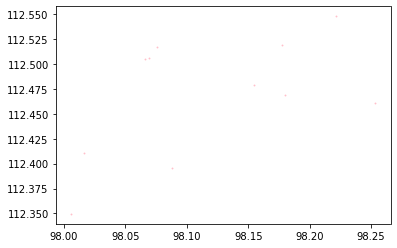

In [ ]:
constItem = None
for item in datamodule.train_dataloader():
    # Others dict is a list of dictionaries, one per SV
    print(item['ego_dict'].keys())
    print(len(item['others_dict']))
    print(item['others_dict'][0].keys())
    print('others len', item['others_len'])
    print('ego track: ', item['ego_dict']['track_id'], item['ego_dict']['history_positions'][0][0], item['ego_dict']['centroid'])
    print('history availability', item['others_dict'][0]['history_availabilities'])
    print(transform_points(item['ego_dict']['centroid'].float(), item['ego_dict']["raster_from_world"][0].float()))

    # pos = transform_points(item['ego_dict']['history_positions'][0].float(), item['ego_dict']["world_from_agent"][0].float())
    # imgPos = worldToImg(pos[None, None, :, :], item['ego_dict']['centroid'], cfg['raster_params'])
    # x, y = imgPos[0][0].detach().numpy().T
    # plt.imshow(rasterizer.to_rgb(item['ego_dict']['image'][0].detach().numpy().transpose(1, 2, 0)))
    # plt.scatter(x, y, s=0.75)
    # print("CENTROID: ", item['ego_dict']['centroid'])
    # x, y = item["ego_dict"]["centroid"].detach().numpy()[0]
    # newX = np.linspace(x+10, x+15, 50)
    # newY = np.linspace(y, y+15, 50)
    # path = torch.tensor([newX, newY]).T
    # transformedPath = worldToImg(path[None, None, :, :], item['ego_dict']['centroid'], cfg['raster_params'])
    # x, y = transformedPath[0][0].detach().numpy().T
    # plt.imshow(rasterizer.to_rgb(item['ego_dict']['image'][0].detach().numpy().transpose(1, 2, 0)))
    # plt.scatter(x, y, s=0.75, color='pink')
    # plt.show()

    print()
    # for k, v in item['ego_dict'].items():
    #     print(k, v.shape)

    print()
    for k, v in item['others_dict'][0].items():
        print(k, v.shape)

    for i in range(len(item['others_dict'])):
        print('track', i, item['others_dict'][i]['track_id'], item['others_dict'][i]['centroid'], item['others_dict'][i]['history_positions'][0][0])

    # print(item['others_dict'][0]['history_positions'].shape, item['others_dict'][0]["world_from_agent"].shape)

    # print(transform_points(item['others_dict'][0]['history_positions'][0].float(), item['others_dict'][0]["world_from_agent"][0].float()))

    # print(item['others_dict'][0]["raster_from_agent"][0], item['others_dict'][1]["raster_from_agent"][0])

    # egorast = transform_points(item['ego_dict']['history_positions'][0].float(), item['ego_dict']["raster_from_agent"][0].float()).detach().numpy()
    
    # plt.imshow(rasterizer.to_rgb(item['ego_dict']['image'][0].detach().numpy().transpose(1, 2, 0)))
    # plt.plot(egorast[:, 0], egorast[:, 1], color='blue')
    # plt.show()

    # plt.plot(egorast[:, 0], egorast[:, 1])

    print('History')
    # plt.imshow(rasterizer.to_rgb(item['ego_dict']['image'][0].detach().numpy().transpose(1, 2, 0)))
    # pos = transform_points(item['ego_dict']['history_positions'][0].float(), item['ego_dict']["world_from_agent"][0].float())
    # imgPos = worldToImg(pos[None, None, :, :], item['ego_dict']['centroid'], cfg['raster_params'])
    # x, y = imgPos[0][0].detach().numpy().T
    # plt.scatter(x, y, s=0.75, color='green')

    for i in range(len(item['others_dict'])):
        poss = transform_points(item['others_dict'][i]['history_positions'][0].float(), item['others_dict'][i]["raster_from_agent"][0].float())
        print(i, 'raster', poss)
        poss2 = transform_points(item['others_dict'][i]['history_positions'][0].float(), item['others_dict'][i]["world_from_agent"][0].float())
        poss3 = transform_points(poss2, item['ego_dict']["raster_from_world"][0].float())
        print('world', poss2)
        print('yaw', item['others_dict'][i]['yaw'])
        # plt.gca().invert_yaxis()
        plt.scatter(poss3[:, 0], poss3[:, 1], s=0.75, color='pink')
        plt.imshow(rasterizer.to_rgb(item['ego_dict']['image'][0].detach().numpy().transpose(1, 2, 0)))

        plt.show()

    # agentsHist = item['others_dict'][:]['history_positions']
    # agentsTransf = item['others_dict'][:]['world_from_agent']

    constItem = item

    # x, y = item['ego_dict']['centroid'][0]
    # plt.scatter(x, y, color='green')
    # for i in range(len(item['others_dict'])):
    #     x, y = item['others_dict'][i]['centroid'][0]
    #     plt.scatter(x, y)
    # plt.axis('square')

    # plt.show()

    # print(item['ego_dict']['image'].shape)
    # for i in range(item['ego_dict']['image'][0].shape[0]):
    #     print(i)
    #     plt.imshow(item['ego_dict']['image'][0][i])
    #     plt.show()

    # plt.imshow(rasterizer.to_rgb(item['ego_dict']['image'][0].detach().numpy().transpose(1, 2, 0)))
    # plt.show()

    break
    

In [ ]:
item = constItem

print(item['others_len'][0], item['others_dict'][0]['history_positions'].shape[1], )
agentsHist = torch.zeros((1, item['others_len'][0], item['others_dict'][0]['history_positions'].shape[1], 3))
yaw = torch.zeros((item['others_dict'][0]['history_positions'].shape[1], 1))

print('agentHist', agentsHist.shape)

raster_from_world = item['ego_dict']['raster_from_world'][0]
posTarget = torch.tensor((raster_from_world[0][2], raster_from_world[1][2], item['ego_dict']['yaw'])).unsqueeze(0).unsqueeze(0)

posAgents = torch.zeros((1, item['others_len'], 3))

for i in range(item['others_len'][0]):
    yaw[:, 0] = item['others_dict'][i]['history_yaws'].squeeze()
    agentsHist[0, i] = torch.cat((item['others_dict'][i]['history_positions'][0], yaw), dim=-1)

    raster_from_world = item['others_dict'][i]['world_from_agent'][0]
    posAgents[0, i] = torch.tensor((raster_from_world[0][2], raster_from_world[1][2], item['others_dict'][i]['yaw']))


print(posAgents.shape, posTarget.shape, posAgents)
j, k, l = torch.split(posAgents, 1, dim=2)
agentsTransf = makeTransformation(posAgents)
print('\n\n\nmatrix:', agentsTransf)
targetTransf = makeTransformation(posTarget)[0]
print(agentsHist.shape, agentsTransf.shape, targetTransf.shape)
pos = worldToImg(agentsHist, agentsTransf, targetTransf)
print('agent', agentsHist)
print(pos)
print('raster from world', raster_from_world)

In [ ]:
a = torch.tensor([1, 2, 3, 4]).detach().numpy()
b = torch.tensor([np.cos(a), np.sin(a)])
torch.cat((b, torch.ones((2, 1))), dim=-1)

In [ ]:
# ===== INIT DATASET
train_cfg = cfg["train_dataloader"]
rasterizer = build_rasterizer(cfg, dm)
train_zarr = ChunkedDataset(dm.require(train_cfg["key"])).open()
train_dataset = AgentDataset(cfg, train_zarr, rasterizer)
train_dataloader = DataLoader(train_dataset, shuffle=train_cfg["shuffle"], batch_size=train_cfg["batch_size"], 
                             num_workers=train_cfg["num_workers"])


dict_keys(['image', 'target_positions', 'target_yaws', 'target_availabilities', 'history_positions', 'history_yaws', 'history_availabilities', 'world_to_image', 'raster_from_world', 'raster_from_agent', 'agent_from_world', 'world_from_agent', 'track_id', 'timestamp', 'centroid', 'yaw', 'extent'])
tensor([[[0.0000e+00, 2.2737e-13]]])


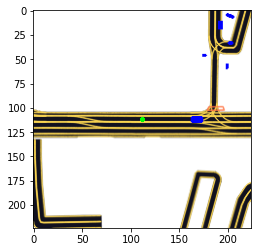

dict_keys(['image', 'target_positions', 'target_yaws', 'target_availabilities', 'history_positions', 'history_yaws', 'history_availabilities', 'world_to_image', 'raster_from_world', 'raster_from_agent', 'agent_from_world', 'world_from_agent', 'track_id', 'timestamp', 'centroid', 'yaw', 'extent'])
tensor([[[0., 0.]]])


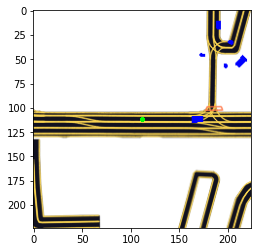

dict_keys(['image', 'target_positions', 'target_yaws', 'target_availabilities', 'history_positions', 'history_yaws', 'history_availabilities', 'world_to_image', 'raster_from_world', 'raster_from_agent', 'agent_from_world', 'world_from_agent', 'track_id', 'timestamp', 'centroid', 'yaw', 'extent'])
tensor([[[0., 0.]]])


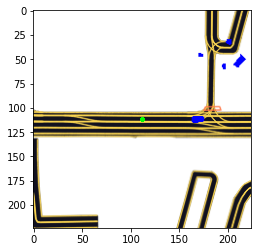

dict_keys(['image', 'target_positions', 'target_yaws', 'target_availabilities', 'history_positions', 'history_yaws', 'history_availabilities', 'world_to_image', 'raster_from_world', 'raster_from_agent', 'agent_from_world', 'world_from_agent', 'track_id', 'timestamp', 'centroid', 'yaw', 'extent'])
tensor([[[0.0000e+00, 2.2737e-13]]])


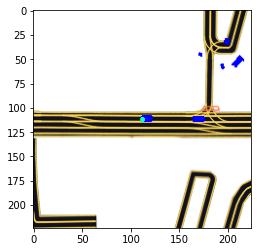

dict_keys(['image', 'target_positions', 'target_yaws', 'target_availabilities', 'history_positions', 'history_yaws', 'history_availabilities', 'world_to_image', 'raster_from_world', 'raster_from_agent', 'agent_from_world', 'world_from_agent', 'track_id', 'timestamp', 'centroid', 'yaw', 'extent'])
tensor([[[2.2737e-13, 0.0000e+00]]])


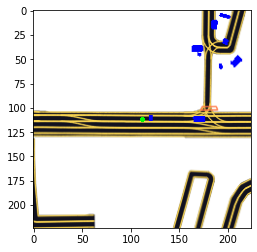

dict_keys(['image', 'target_positions', 'target_yaws', 'target_availabilities', 'history_positions', 'history_yaws', 'history_availabilities', 'world_to_image', 'raster_from_world', 'raster_from_agent', 'agent_from_world', 'world_from_agent', 'track_id', 'timestamp', 'centroid', 'yaw', 'extent'])
tensor([[[2.2737e-13, 0.0000e+00]]])


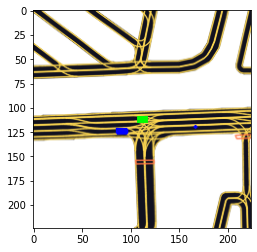

dict_keys(['image', 'target_positions', 'target_yaws', 'target_availabilities', 'history_positions', 'history_yaws', 'history_availabilities', 'world_to_image', 'raster_from_world', 'raster_from_agent', 'agent_from_world', 'world_from_agent', 'track_id', 'timestamp', 'centroid', 'yaw', 'extent'])
tensor([[[2.2737e-13, 0.0000e+00]]])


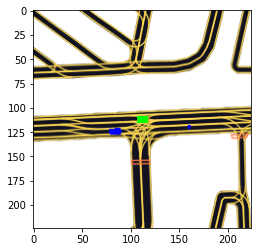

In [ ]:
count = 5
for item in train_dataloader:
    plt.imshow(rasterizer.to_rgb(item['image'][0].detach().numpy().transpose(1, 2, 0)))
    print(item.keys())
    print(item['history_positions'])
    plt.show()
    if count < 0:
        break
    count -= 1

In [ ]:
# ==== INIT MODEL
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = build_model(cfg).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss(reduction="none")

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


# Training

note: if you're on MacOS and using `py_satellite` rasterizer, you may need to disable opencv multiprocessing by adding:
`cv2.setNumThreads(0)` before the following cell. This seems to only affect running in python notebook and it's caused by the `cv2.warpaffine` function

In [ ]:
# ==== TRAIN LOOP
tr_it = iter(train_dataloader)
progress_bar = tqdm(range(cfg["train_params"]["max_num_steps"]))
losses_train = []
for _ in progress_bar:
    try:
        data = next(tr_it)
    except StopIteration:
        tr_it = iter(train_dataloader)
        data = next(tr_it)
    model.train()
    torch.set_grad_enabled(True)
    loss, _ = forward(data, model, device, criterion)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses_train.append(loss.item())
    progress_bar.set_description(f"loss: {loss.item()} loss(avg): {np.mean(losses_train)}")

loss: 0.35441944003105164 loss(avg): 6.989409580826759: 100%|██████████| 5/5 [00:10<00:00,  2.03s/it]


### Plot Loss Curve
We can plot the train loss against the iterations (batch-wise)

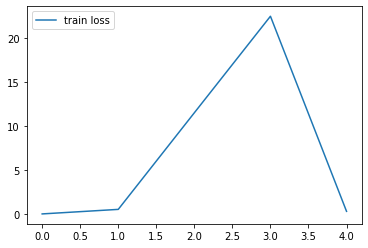

In [ ]:
plt.plot(np.arange(len(losses_train)), losses_train, label="train loss")
plt.legend()
plt.show()

# Evaluation

Evaluation follows a slightly different protocol than training. When working with time series, we must be absolutely sure to avoid leaking the future in the data.

If we followed the same protocol of training, one could just read ahead in the `.zarr` and forge a perfect solution at run-time, even for a private test set.

As such, **the private test set for the competition has been "chopped" using the `chop_dataset` function**.

In [ ]:
# ===== GENERATE AND LOAD CHOPPED DATASET
num_frames_to_chop = 100
eval_cfg = cfg["val_dataloader"]
eval_base_path = create_chopped_dataset(dm.require(eval_cfg["key"]), cfg["raster_params"]["filter_agents_threshold"], 
                              num_frames_to_chop, cfg["model_params"]["future_num_frames"], MIN_FUTURE_STEPS)

/usr/local/lib/python3.6/dist-packages/l5kit/data/zarr_utils.py:243: RuntimeWarning: zarr dataset path doesn't exist. Open will fail for this dataset!
  output_dataset = ChunkedDataset(output_zarr)
copying: 100%|██████████| 100/100 [00:02<00:00, 42.01it/s]
/usr/local/lib/python3.6/dist-packages/l5kit/evaluation/extract_ground_truth.py:59: RuntimeWarning: you're running with a custom agents_mask
  dataset = AgentDataset(cfg=cfg, zarr_dataset=zarr_dataset, rasterizer=rasterizer, agents_mask=agents_mask)
extracting GT: 100%|██████████| 480/480 [00:06<00:00, 71.96it/s]


The result is that **each scene has been reduced to only 100 frames**, and **only valid agents in the 100th frame will be used to compute the metrics**. Because following frames in the scene have been chopped off, we can't just look ahead to get the future of those agents.

In this example, we simulate this pipeline by running `chop_dataset` on the validation set. The function stores:
- a new chopped `.zarr` dataset, in which each scene has only the first 100 frames;
- a numpy mask array where only valid agents in the 100th frame are True;
- a ground-truth file with the future coordinates of those agents;

Please note how the total number of frames is now equal to the number of scenes multipled by `num_frames_to_chop`. 

The remaining frames in the scene have been sucessfully chopped off from the data

In [ ]:
eval_zarr_path = str(Path(eval_base_path) / Path(dm.require(eval_cfg["key"])).name)
eval_mask_path = str(Path(eval_base_path) / "mask.npz")
eval_gt_path = str(Path(eval_base_path) / "gt.csv")

eval_zarr = ChunkedDataset(eval_zarr_path).open()
eval_mask = np.load(eval_mask_path)["arr_0"]
# ===== INIT DATASET AND LOAD MASK
eval_dataset = AgentDataset(cfg, eval_zarr, rasterizer, agents_mask=eval_mask)
eval_dataloader = DataLoader(eval_dataset, shuffle=eval_cfg["shuffle"], batch_size=eval_cfg["batch_size"], 
                             num_workers=eval_cfg["num_workers"])
print(eval_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   10000    |   751440   |     130740    |       0.28      |        100.00        |        75.14         |        10.00         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: you're running with a custom agents_mask
  


### Storing Predictions
There is a small catch to be aware of when saving the model predictions. The output of the models are coordinates in `agent` space and we need to convert them into displacements in `world` space.

To do so, we first convert them back into the `world` space and we then subtract the centroid coordinates.

In [ ]:
# ==== EVAL LOOP
model.eval()
torch.set_grad_enabled(False)

# store information for evaluation
future_coords_offsets_pd = []
timestamps = []
agent_ids = []

progress_bar = tqdm(eval_dataloader)
for data in progress_bar:
    _, ouputs = forward(data, model, device, criterion)
    
    # convert agent coordinates into world offsets
    agents_coords = ouputs.cpu().numpy()
    world_from_agents = data["world_from_agent"].numpy()
    centroids = data["centroid"].numpy()
    coords_offset = []
    
    for agent_coords, world_from_agent, centroid in zip(agents_coords, world_from_agents, centroids):
        coords_offset.append(transform_points(agent_coords, world_from_agent) - centroid[:2])
    
    future_coords_offsets_pd.append(np.stack(coords_offset))
    timestamps.append(data["timestamp"].numpy().copy())
    agent_ids.append(data["track_id"].numpy().copy())
    


  0%|          | 0/40 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

### Save results
After the model has predicted trajectories for our evaluation set, we can save them in a `csv` file.

During the competition, only the `.zarr` and the mask will be provided for the private test set evaluation.
Your solution is expected to generate a csv file which will be compared to the ground truth one on a separate server

In [ ]:
pred_path = f"{gettempdir()}/pred.csv"

write_pred_csv(pred_path,
               timestamps=np.concatenate(timestamps),
               track_ids=np.concatenate(agent_ids),
               coords=np.concatenate(future_coords_offsets_pd),
              )

In [ ]:
print(pred_path)

### Perform Evaluation
Pleae note that our metric supports multi-modal predictions (i.e. multiple predictions for a single GT trajectory). In that case, you will need to provide a confidence for each prediction (confidences must all be between 0 and 1 and sum to 1).

In this simple example we don't generate multiple trajectories, so we won't pass any confidences vector. Internally, the metric computation will assume a single trajectory with confidence equal to 1

In [ ]:
metrics = compute_metrics_csv(eval_gt_path, pred_path, [neg_multi_log_likelihood, time_displace])
for metric_name, metric_mean in metrics.items():
    print(metric_name, metric_mean)


### Visualise Results
We can also visualise some results from the ego (AV) point of view for those frames of interest (the 100th of each scene).

However, as we chopped off the future from the dataset **we must use the GT csv if we want to plot the future trajectories of the agents**


(25, 224, 224)


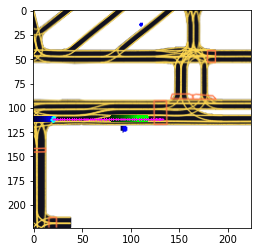

In [ ]:
model.eval()
torch.set_grad_enabled(False)

# build a dict to retrieve future trajectories from GT
gt_rows = {}
for row in read_gt_csv(eval_gt_path):
    gt_rows[row["track_id"] + row["timestamp"]] = row["coord"]

eval_ego_dataset = EgoDataset(cfg, eval_dataset.dataset, rasterizer)

for frame_number in range(99, len(eval_zarr.frames), 100):  # start from last frame of scene_0 and increase by 100
    agent_indices = eval_dataset.get_frame_indices(frame_number) 
    if not len(agent_indices):
        continue

    # get AV point-of-view frame
    data_ego = eval_ego_dataset[frame_number]
    print(data_ego['image'].shape)
    im_ego = rasterizer.to_rgb(data_ego["image"].transpose(1, 2, 0))
    center = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]
    
    predicted_positions = []
    target_positions = []

    for v_index in agent_indices:
        data_agent = eval_dataset[v_index]

        out_net = model(torch.from_numpy(data_agent["image"]).unsqueeze(0).to(device))
        out_pos = out_net[0].reshape(-1, 2).detach().cpu().numpy()
        # store absolute world coordinates
        predicted_positions.append(transform_points(out_pos, data_agent["world_from_agent"]))
        # retrieve target positions from the GT and store as absolute coordinates
        track_id, timestamp = data_agent["track_id"], data_agent["timestamp"]
        target_positions.append(gt_rows[str(track_id) + str(timestamp)] + data_agent["centroid"][:2])


    # convert coordinates to AV point-of-view so we can draw them
    predicted_positions = transform_points(np.concatenate(predicted_positions), data_ego["raster_from_world"])
    target_positions = transform_points(np.concatenate(target_positions), data_ego["raster_from_world"])

    draw_trajectory(im_ego, predicted_positions, PREDICTED_POINTS_COLOR)
    draw_trajectory(im_ego, target_positions, TARGET_POINTS_COLOR)

    plt.imshow(im_ego[::-1])
    plt.show()